In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [29]:
path = 'data/data.csv'
df = pd.read_csv(path, encoding='ISO-8859-1') # Using a different encoding while info is fixed

In [77]:
df['Abstract']

0      Ataxia and Parkinson's Disease (PD) are two of...
1      Novel disease-modifying therapies are being ev...
2      Assessment of motor severity in cerebellar ata...
3      Friedreichs ataxia (FA) is caused by the down...
4       In this study, it is aimed to detect ataxia f...
                             ...                        
219    Tourette syndrome (TS) is a developmental neur...
220    Patients with Parkinson's disease often experi...
221    Background: Chronic use of medication for trea...
222    We developed an objective and automatic proced...
223    Background: This study aimed to detect ataxia ...
Name: Abstract, Length: 224, dtype: object

In [75]:
df['Year'].value_counts()

2023    42
2024    39
2022    31
2021    24
2020    23
2019    14
2018    14
2016     9
2017     6
2012     6
2015     5
0        4
2003     2
2014     2
2010     2
2013     1
Name: Year, dtype: int64

In [44]:
df['Year'].max()

2024.0

In [71]:
type(df['Country'].value_counts())

pandas.core.series.Series

In [66]:
# Converting Year to int. Filling NaN with 0
df['Year'] = df['Year'].fillna(0).astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Authors                223 non-null    object
 1   Year                   224 non-null    int64 
 2   Paper                  223 non-null    object
 3   Country                220 non-null    object
 4   MDS                    221 non-null    object
 5   Data Source Primary    6 non-null      object
 6   Data Source Secondary  221 non-null    object
 7   Algorithm              222 non-null    object
 8   Task                   187 non-null    object
 9   Cross Validation       170 non-null    object
 10  Performance Metric     200 non-null    object
 11  Sample Size            189 non-null    object
 12  Dataset                188 non-null    object
 13  Goal                   200 non-null    object
 14  Abstract               196 non-null    object
 15  Person                 

In [6]:
# df[df['Country'] == 'US, Canada, UK']

In [83]:
df['Year'].max()

2024

In [88]:
country_counts

USA                      38
China                    26
India                    19
Italy                    12
Netherlands              11
                         ..
India                     1
Canada, Ireland, USA      1
Iran, Italy               1
Italy, Mexico             1
Germany, Portugal, UK     1
Name: Country, Length: 71, dtype: int64

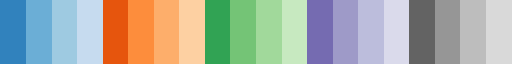

In [96]:
cm.tab20c

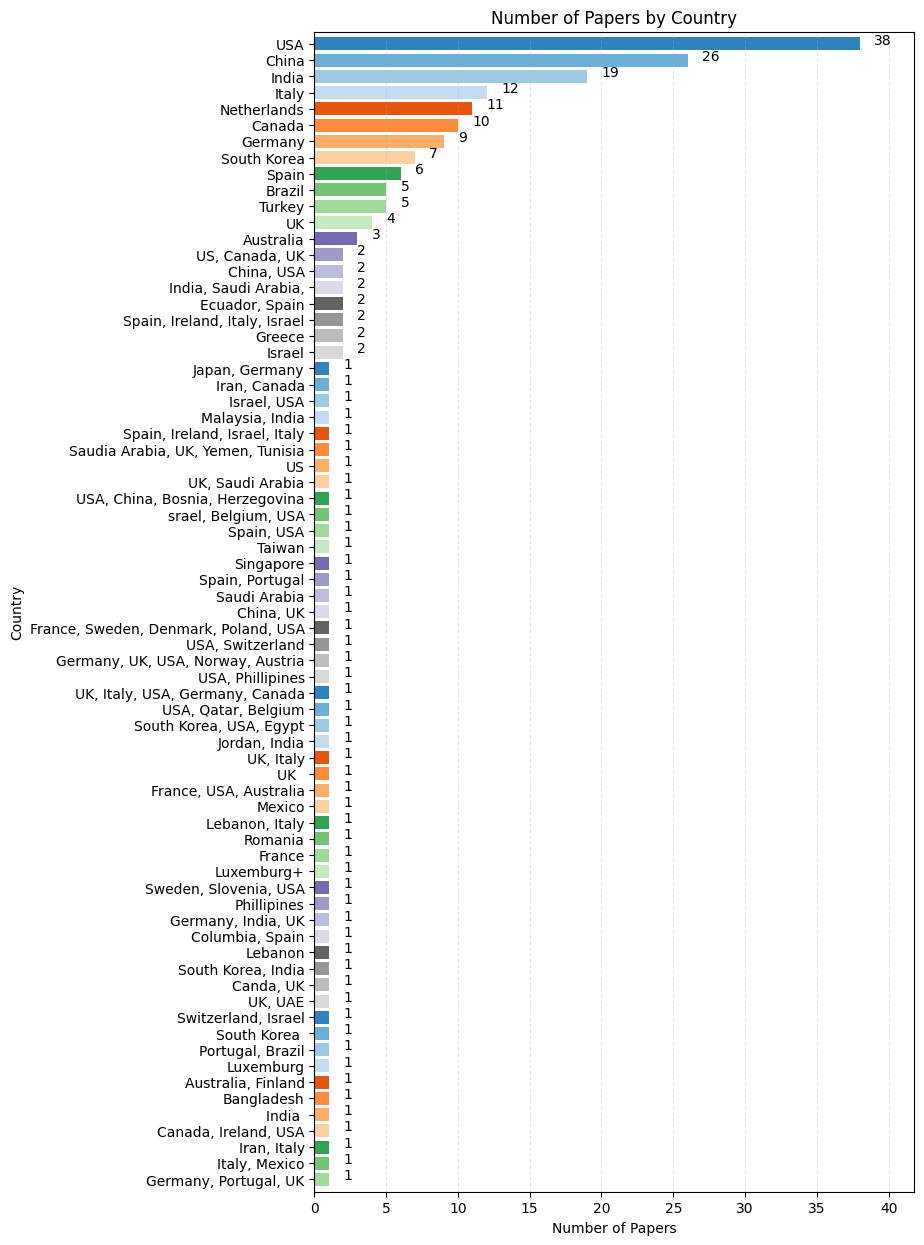

In [97]:
# Plot the horizontal bar graph with spacing between bars
country_counts = df['Country'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(country_counts.index, country_counts.values, color=cm.tab20c.colors[:len(country_counts)])
# Set the x-axis label
max_count = country_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Country')
plt.title('Number of Papers by Country')

for i, v in enumerate(country_counts.values):
        plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=1.5, bottom=0.05)
plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

In [8]:
df['MDS'].value_counts()

PD                                                                          50
Freezing of Gait                                                            30
TS                                                                          26
Bradykinesia                                                                23
Dyskinesia                                                                  19
Dystonia                                                                     9
Dyskinesia, PD                                                               9
Isolated Dystonia                                                            5
Bradykinesia                                                                 5
Ataxia                                                                       4
Cervical Dystonia                                                            4
Ataxia (Multiple Sclerosis)                                                  3
PD                                                  

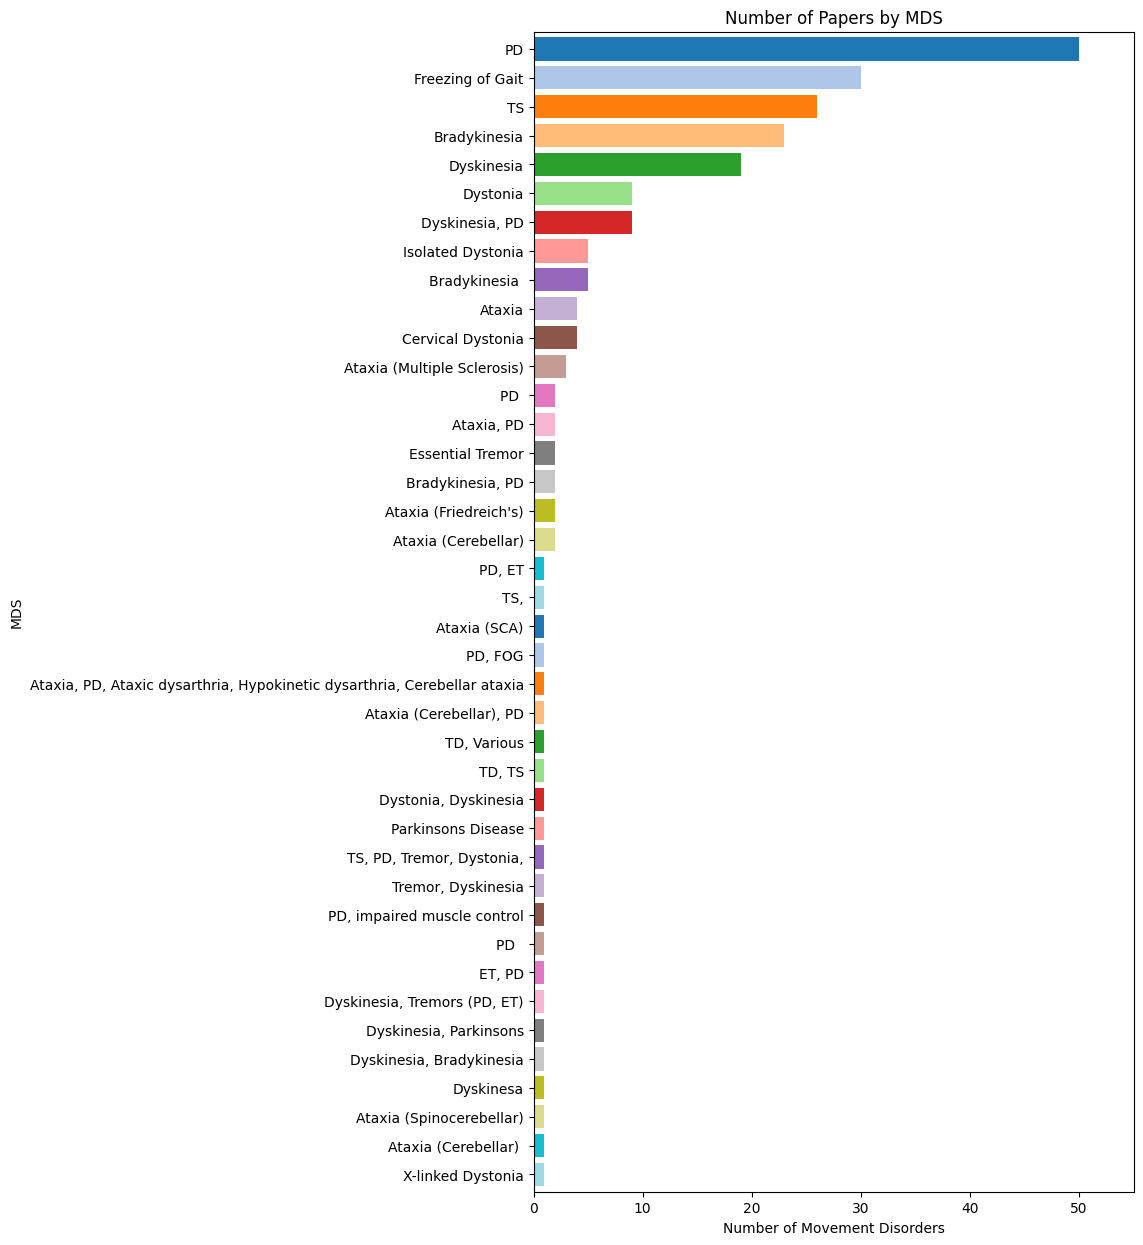

In [98]:
# Plot the horizontal bar graph with spacing between bars
mds_counts = df['MDS'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(mds_counts.index, mds_counts.values, color=cm.tab20.colors[:len(mds_counts)])
# Set the x-axis label
max_count = mds_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Movement Disorders')
plt.ylabel('MDS')
plt.title('Number of Papers by MDS')

# for i, v in enumerate(mds_counts.values):
#         plt.text(v + 1, i, str(v))


# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=1.5, bottom=0.05)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

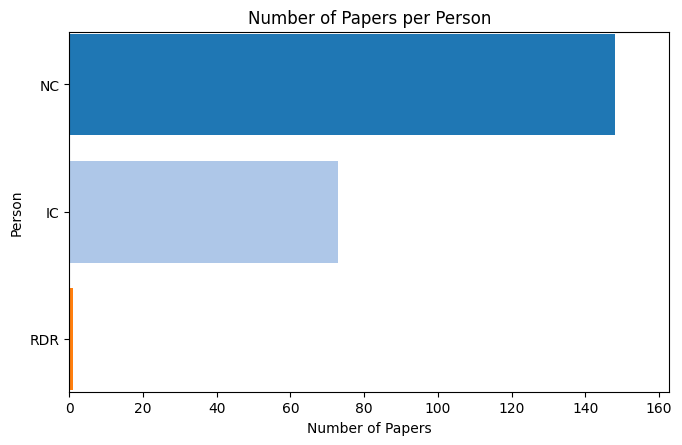

In [25]:
# Plot the horizontal bar graph with spacing between bars
person_counts = df['Person'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(person_counts.index, person_counts.values, color=cm.tab20.colors[:len(person_counts)])
# Set the x-axis label
max_count = person_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Person')
plt.title('Number of Papers per Person')

# for i, v in enumerate(person_counts.values):
#         plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=0.5, bottom=0.05)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()